## Imports



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

#Facebook Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

/home/zenanahmed/.pyenv/versions/3.8.12/envs/Team_Energy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
# https://storage.googleapis.com/energy_consumption_903/df_all_avg_tariff_v3.csv
# https://storage.googleapis.com/energy_consumption_903/df_all_avg_v3.csv

## Data-Split

In [2]:
def split_data(filename):
#     print('Input precise path for data including extension')
#     filename = input()
    fulldata = pd.read_csv(filename)
    fulldata['DateTime'] = pd.to_datetime(fulldata['DateTime'])
    train_data = fulldata[(fulldata['DateTime'] >= '2012-01-01') & (fulldata['DateTime'] < '2014-01-01')].reset_index(drop = True)
    validation_data = fulldata[(fulldata['DateTime'] >= '2014-01-01') & (fulldata['DateTime'] < '2014-02-01')].reset_index(drop = True)
    test_data = fulldata[(fulldata['DateTime'] >= '2014-02-01') & (fulldata['DateTime'] < '2014-03-01')].reset_index(drop = True)
    return train_data, validation_data, test_data

## Data-Processing 

In [163]:
def create_data(Acorn_group,Tariff):
    tdata, vdata, testd=split_data(f'https://storage.googleapis.com/energy_usage_prediction_903/df_{Acorn_group}_avg_v1.csv')
    twd, vwd, testwd=split_data('https://storage.googleapis.com/weather-data-processed-for-le-wagon/cleaned_weather_hourly_darksky.csv')
    # add val and train for prophet
    pdata=pd.concat([tdata,vdata],axis=0).reset_index(drop=True)

    global_average=False

    if global_average==False:
        # not for global average
        pdata.drop(columns='Unnamed: 0',inplace=True)
        testd.drop(columns='Unnamed: 0',inplace=True)
        train_df=pdata.loc[:,['DateTime','KWH/hh']]
        test_df=testd.loc[:,['DateTime','KWH/hh']]
    else:
        # group all for dumb models
        df5=pdata.loc[:,['DateTime','Acorn_Group','KWH/hh']]
        df5.set_index('DateTime',inplace=True)
        train_df=df5.groupby(by=df5.index).mean()
        train_df=train_df.reset_index()
        test_df=testd.loc[:,['DateTime','Acorn_Group','KWH/hh']].groupby(by=testd['DateTime']).mean()
        test_df.reset_index(inplace=True)
    return train_df,test_df

train_df,test_df=create_data('E','STD')

## Optional Parameters

### Holidays

In [149]:
holidays=pd.read_csv(os.path.join(os.getcwd(),'../raw_data/uk_bank_holidays.csv'))
holidays.rename(columns={'Type':'holiday','Bank holidays':'ds'},inplace=True)
holidays.loc[:,'ds']=pd.to_datetime(holidays['ds'],format="%d/%m/%Y")
holidays.head()

,holiday,ds
0,Boxing Day,2012-12-26
1,Christmas Day,2012-12-25
2,Summer bank holiday,2012-08-27
3,Queen's Diamond Jubilee,2012-05-06
4,Spring bank holiday,2012-04-06


### Weather

In [150]:
wd_filt=wd[['DateTime','temperature','windSpeed','precipType_rain']].dropna()
wd_filt['DateTime']=pd.to_datetime(wd_filt['DateTime'])
test_wd=testwd[['DateTime','temperature','windSpeed','precipType_rain']].dropna()
test_wd['DateTime']=pd.to_datetime(test_wd['DateTime'])
# # wind = wd_filt['windSpeed'].interpolate(method='linear')
# # rain = wd_filt['precipType_rain'].interpolate(method='linear')
train_wd=train_df[['DateTime']].merge(wd_filt,on='DateTime',how='inner')
test_wd=test_df[['DateTime']].merge(test_wd,on='DateTime',how='inner')
test_wd

,DateTime,temperature,windSpeed,precipType_rain
0,2014-02-01 00:00:00,9.24,6.78,1.0
1,2014-02-01 01:00:00,9.31,5.83,1.0
2,2014-02-01 02:00:00,9.72,6.07,1.0
3,2014-02-01 03:00:00,9.18,6.31,1.0
4,2014-02-01 04:00:00,6.73,4.69,1.0
...,...,...,...,...
644,2014-02-27 20:00:00,5.94,3.25,1.0
645,2014-02-27 21:00:00,5.03,3.06,1.0
646,2014-02-27 22:00:00,4.10,3.02,1.0
647,2014-02-27 23:00:00,3.93,2.75,1.0


## Train

In [151]:
def train_model(train_df,train_wd,holidays,add_weather=True): 
    train_df.rename(columns={"DateTime": "ds", "KWH/hh": "y"},inplace=True)
    if add_weather==True:  
        temp = train_wd['temperature'].interpolate(method='linear')
        train_df['temp']=temp
        m = Prophet(holidays=holidays,changepoint_prior_scale=0.01).add_regressor('temp', prior_scale=0.5, mode='multiplicative')
        m.fit(train_df)
    else:
        m = Prophet(holidays=holidays,changepoint_prior_scale=0.01)
        m.fit(train_df)
    return m

In [164]:
m=train_model(train_df,train_wd,holidays,add_weather=False)

17:58:14 - cmdstanpy - INFO - Chain [1] start processing
17:58:32 - cmdstanpy - INFO - Chain [1] done processing


## Predict

In [153]:
def forecast_model(m,train_wd,test_wd,holidays,add_weather=True): 
    future = m.make_future_dataframe(periods=48*27+1, freq='30T')
    if add_weather==True:   
        wd_filt_future=future[['ds']].merge(pd.concat([future,pd.concat([train_wd,test_wd],axis=0)]),left_on='ds',right_on='DateTime',how='inner').drop(columns='DateTime')
        temp_future=wd_filt_future['temperature'].interpolate(method='linear')
        future['temp']=temp_future
        fcst = m.predict(future)
    else:
        fcst = m.predict(future)
    return fcst

In [165]:
f=forecast_model(m,train_wd,test_wd,holidays,add_weather=False)

## Plot

In [173]:
def plot_graphs(f):
    forecast=f.loc[f['ds']>='2014-02-01 00:00:00',['ds','yhat']]
    figure(figsize=(15,6))
    sns.lineplot(x=forecast['ds'],y=forecast['yhat'],label='Forecast');
    sns.lineplot(x=test_df['DateTime'],y=test_df['KWH/hh'],label='Actual');
    figure(figsize=(15,6))
    sns.lineplot(x=test_wd['DateTime'],y=test_wd['temperature'],label='Weather');

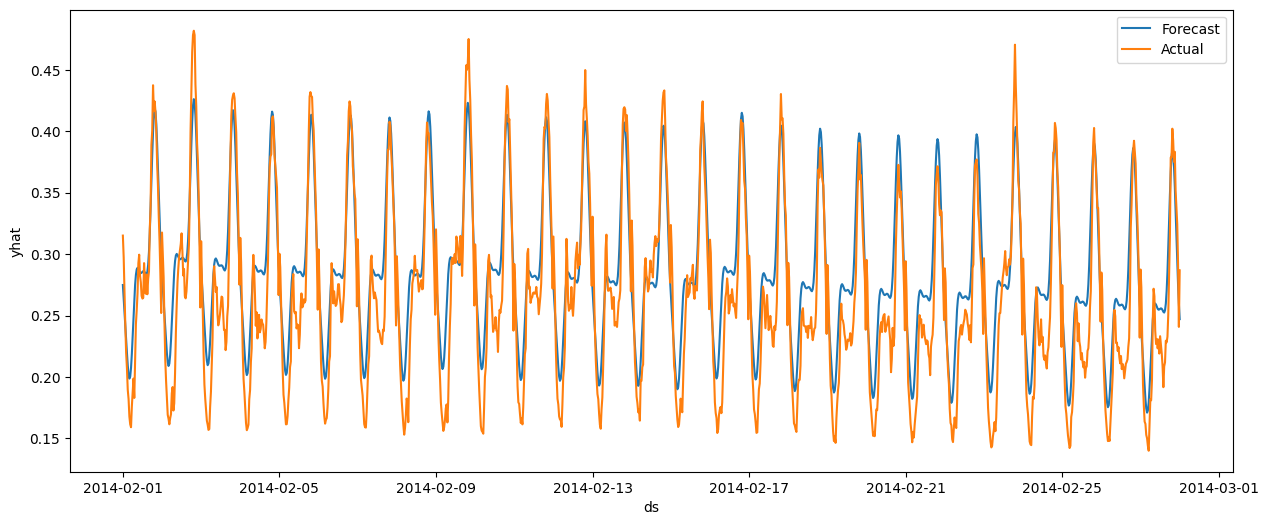

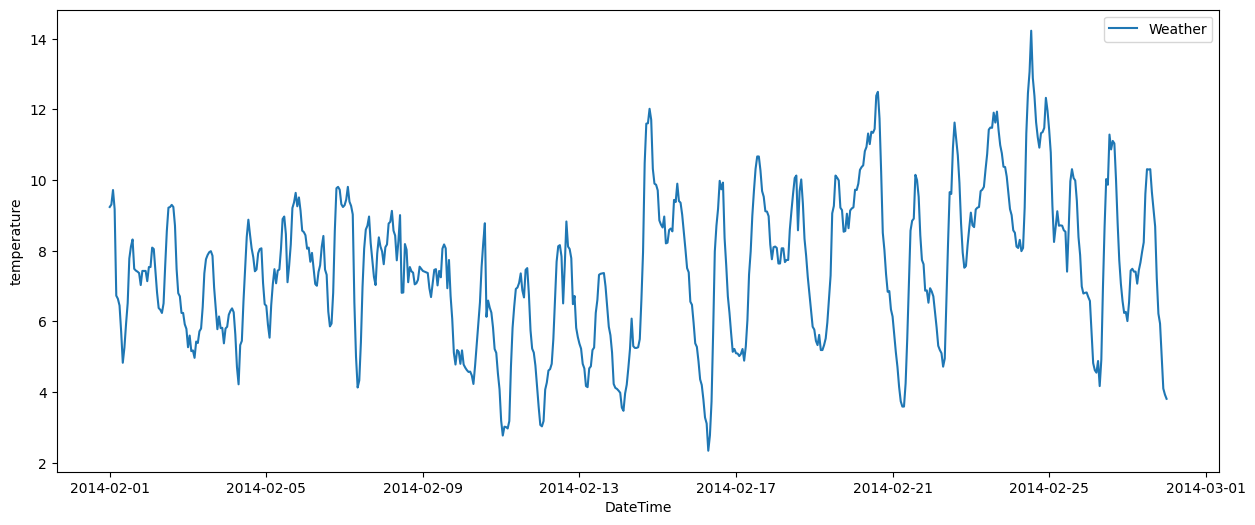

In [174]:
plot_graphs(f)